In [1]:
from langchain_mcp_adapters.client import MultiServerMCPClient
from langgraph.prebuilt import create_react_agent
from langchain_ollama import ChatOllama
from langchain.globals import set_debug
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage
from typing import TypedDict, List
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph, END, START
import uuid

MCP_SERVER_URL="http://localhost:8000/sse"
OLLAMA_URL="http://localhost:11434"

client = MultiServerMCPClient(
    {
        "Demo": {
            "url": MCP_SERVER_URL,
            "transport": "sse",
        }
    }
)

llm = ChatOllama(model="qwen3:8b", base_url=OLLAMA_URL, reasoning=True, temperature=0)
tools = await client.get_tools()
prompts = await client.get_prompt('Demo', 'configure_assistant')

agent = create_react_agent(
    llm,
    tools, 
    prompt=prompts[0].content
)

class AgentState(TypedDict):
    messages: List[AnyMessage]

In [2]:
async def reasoning_node(state: AgentState):
    last_msg_text = next((m.content for m in reversed(state["messages"]) if isinstance(m, HumanMessage)), "<no message provided>") 
    state["messages"].append(AIMessage(content=f"Message - In reasoning node ..."))
    
    request = {
        "messages": [HumanMessage(content=last_msg_text)]
    }
    
    result = await agent.ainvoke(request)
    state['messages'] += result['messages']
    return {**state}

# Create a start node that does nothing but pass through
def start_node(state: AgentState):
    # No action; just pass through
    return state


In [3]:
graph = StateGraph(AgentState)

# Graph odes
graph.add_node("start_node", start_node)
graph.add_node("reasoning_node", reasoning_node)

# Graph edges
graph.set_entry_point("start_node")
graph.add_edge("start_node", "reasoning_node")
graph.add_edge("reasoning_node", END)

checkpointer = InMemorySaver()
app = graph.compile(checkpointer=checkpointer)

In [4]:
# Function to call model
async def async_call_model(graph, state, config):
    res = await graph.ainvoke(state, config)
    return res

In [5]:
thread_id = str(uuid.uuid4())

state: AgentState = {
    "messages": []
} 

config = {"configurable": {"thread_id": thread_id}, "recursion_limit": 100}

In [6]:
# Example of invoking the graph outside of while loop
# state['messages'].append(HumanMessage(content="What is Susan Davis's availability?"))
# resp = await async_call_model(app, state, config)
# print(resp['messages'][-1].content)

In [7]:
# Example of invoking the graph again outside of while loop
# state['messages'].append(HumanMessage(content="What are client 123's appointments?"))
# resp = await async_call_model(app, state, config)
# print(resp['messages'][-1].content)

In [10]:
# Loop that asks for user input until the user types 'exit'
while True:
    # Prompt for user input
    user_input = input("Type your question (or 'exit' to quit): ")

    # If the user types 'exit', break out of the loop
    if user_input.lower() == 'exit':
        print("Exiting the loop.")
        break

    # Append the user input to the state as a HumanMessage
    state['messages'].append(HumanMessage(content=user_input))
    
    # Call the model and get a response
    resp = await async_call_model(app, state, config)
    
    # Print the response
    print(resp['messages'][-1].content)
    print()


Type your question (or 'exit' to quit):  What is susan david's availability ?


Here are the available booking slots for Susan David:

- Slot 1 at 2024-08-20 10:00:00
- Slot 2 at 2024-08-20 11:00:00
- Slot 3 at 2024-08-20 14:00:00
- Slot 4 at 2024-08-20 15:00:00
- Slot 5 at 2024-08-20 16:00:00



Type your question (or 'exit' to quit):  What are client 123's appointments?


Client 123 has no booked appointments.



Type your question (or 'exit' to quit):  What does client 007 have for appointments?


Here are the booked appointments for client 007:

1. **Provider:** susan davis | **Slot:** 37 | **Time:** 2024-08-07 08:00:00  
2. **Provider:** susan davis | **Slot:** 39 | **Time:** 2024-08-07 09:00:00  
3. **Provider:** susan davis | **Slot:** 40 | **Time:** 2024-08-07 09:30:00  
4. **Provider:** susan davis | **Slot:** 175 | **Time:** 2024-08-16 10:00:00  

Let me know if you need to cancel or adjust any slots.



Type your question (or 'exit' to quit):  what providers work at our long-term care facility?


Here are the providers working at the long-term care facility along with their roles:

1. **Susan Davis** - Registered Nurse  
2. **Lisa Brown** - Occupational Therapist  
3. **Daniel Miller** - Geriatrician  
4. **Emily Johnson** - Social Worker  
5. **Jane Smith** - Nutritionist  
6. **John Doe** - Physical Therapist  
7. **Kevin Anderson** - General Practitioner  
8. **Michael Green** - Pharmacist  
9. **Robert Martinez** - Care Coordinator  
10. **Sarah Wilson** - Home Health Aide  

Let me know if you need further details!



Type your question (or 'exit' to quit):  exit


Exiting the loop.


In [ ]:
# Print graph topology

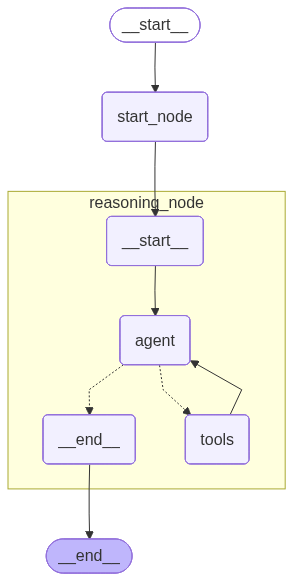

In [9]:
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png(max_retries=5, retry_delay=2.0)))